## GMM on synthetic data
The first step is to load the data from the "synthetic_data.csv" to a numpy array.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(3)

X = np.genfromtxt("synthetic_data.csv", delimiter=',')
print(X.shape)

n = X.shape[0]
p = X.shape[1]

(200, 2)


We first take a look at how the data look like.

[]

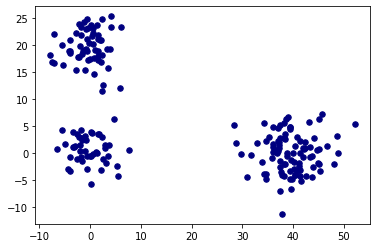

In [2]:
plt.scatter(X[:, 0], X[:, 1], color='navy', s=30)
plt.plot()

There are roughly 3 clusters.

$\lambda_i$ are initialized uniformly. Each is $\frac{1}{3}$.

$\mu_i$ are initialized with 3 samples randomly selected from $X$.

$\sigma^2_i$ are uniformly sampled from $(1., 2.)$.

In [3]:
k = 3
lambdas = np.ones((k))/k
mus = X[np.random.choice(n, k), :]
#mus = np.array([[1., 1.], [1., 21.], [41, 1]])
sigma2s = np.random.random_sample(k) + 1. # initial variance cannot be too small

print(lambdas)
print(mus)
print(sigma2s)

[0.33333333 0.33333333 0.33333333]
[[36.534    0.46896]
 [-1.9612   0.40852]
 [ 3.6098  -0.58749]]
[1.29090474 1.51082761 1.89294695]


Furthermore, we define a pdf function here to calculate the likelihood.

In [4]:
def log_pdf(X, mean, variance):
    n = len(X)
    log_pdf_list = []
    for i in range(n):
        log_pdf = np.log(1. / (2. * np.pi * variance)**(p/2)) - 1./(2.*variance) * np.matmul((X[i]-mean).T, X[i]-mean)
        log_pdf_list.append(log_pdf)
    return np.array(log_pdf_list)

Now we start to fit the Gaussian Mixture Model (GMM):

### Expectation Step

Compute $P_i(z_i=j|X_i, \theta^{t-1})=\frac{\lambda_j^{t-1}N(X_i;\mu_j^{t-1}, (\sigma_j^{t-1})^2)}{\sum_{k=1}^3\lambda_k^{t-1}N(X_i;\mu_k^{t-1}, (\sigma_k^{t-1})^2)}=p_i^{t-1}(j)$

### Likelihood for step t-1

$\ell(\theta^{t-1};X)=L(P(Z|X,\theta^{t-1}), \theta^{t-1})=\sum_{i=1}^n\sum_{z_i=1}^3 P(z_i|X_i, \theta^{t-1}) \log \frac{P(X_i, z_i|\theta^{t-1})}{P(z_i|X_i, \theta^{t-1})}=\sum_{i=1}^n\sum_{j=1}^3 p^{t-1}_i(j)\log \frac{P(X_i, z_i=j|\theta^{t-1})}{p^{t-1}_i(j)}=$
$\sum_{i=1}^n \log P(X_i|\theta^{t-1})=\sum_{i=1}^n \log \sum_{j=1}^3 P(X_i, z_i=j|\theta^{t-1})$

### Maximization Step

$\hat{\mu}_j=\frac{\sum_{i=1}^n p_i^{t-1}(j)X_i}{\sum_{i=1}^n p_i^{t-1}(j)}$

$\hat{\sigma}_j^2=\frac{\sum_{i=1}^n p_i^{t-1}(j)(X_i-\hat{\mu}_j)^T(X_i-\hat{\mu}_j)}{p\sum_{i=1}^n p_i^{t-1}(j)}$

In [5]:
eps = 1e-6
log_likelihoods = []
est_errors = []

lambda1 = 0.2
lambda2 = 0.3
mu1 = np.array([0, 0.])
mu2 = np.array([0, 20.])
mu3 = np.array([40., 0])
sigma1 = 10
sigma2 = 10
sigma3 = 15

clusters = np.zeros(n, dtype=int)

for step in range(30):
    # Expectation step (p_i^{t-1}(j)): 
    ## sub-step 1: Compute N(X_i;\mu_j^{t-1}, (\sigma_j^{t-1})^2) for each X_i. (likelihood)
    log_lld = []
    for j in range(k):
        log_lld.append(log_pdf(X, mus[j], sigma2s[j]))
    log_lld = np.array(log_lld)
    max_log_lld = np.amax(log_lld, axis=0)
    ## sub-step 2: Compute p_i^{t-1}(j)
    p_ij = np.zeros((n, k), dtype=np.float32)
    for i in range(n):
        norm_term = 0.
        for j in range(k):
            norm_term += lambdas[j] * np.exp(log_lld[j, i]-max_log_lld[i])
        for j in range(k):
            p_ij[i, j] = lambdas[j] * np.exp(log_lld[j, i]-max_log_lld[i]) / norm_term
        clusters[i] = np.argmax(p_ij[i, :])
    
    # log-Likelihood
    lld = 0.
    for i in range(n):
        norm_term = 0.
        for j in range(k):
            norm_term += lambdas[j] * np.exp(log_lld[j, i]-max_log_lld[i])
        lld += np.log(norm_term) + max_log_lld[i]
    log_likelihoods.append([step-1, lld])
    
    # estimation error
    est_err = 0.
    min_lambda_err = 1e8
    min_mu_sigma_err = 1e8
    # enumerate possible lambda matching
    for i in range(2):
        for j in range(2):
            if i != j:
                err = (lambdas[i]-lambda1)**2 + (lambdas[j]-lambda2)**2
                if err < min_lambda_err:
                    min_lambda_err = err
    est_err += min_lambda_err
    # enumerate possible mu matching
    for i in range(3):
        for j in range(3):
            if i != j:
                for w in range(3):
                    if w != i and w != j:
                        err = np.matmul((mus[i]-mu1).T, mus[i]-mu1) + np.matmul((mus[j]-mu2).T, mus[j]-mu2) + np.matmul((mus[w]-mu3).T, mus[w]-mu3) + \
                            (sigma2s[i]-sigma1)**2 + (sigma2s[j]-sigma2)**2 + (sigma2s[w]-sigma3)**2
                        if err < min_mu_sigma_err:
                            min_mu_sigma_err = err
    est_err += min_mu_sigma_err
    est_errors.append([step-1, est_err])
    
    # Maximization step (Update \lambda_j, \mu_j, \sigma^2_j)
    for j in range(k):
        # update \lambda's
        sum_weight = 0.
        for i in range(n):
            sum_weight += p_ij[i, j]
        lambdas[j] = sum_weight / n
        
        # update means
        sum_weighted_mean = np.zeros(p)
        for i in range(n):
            sum_weighted_mean += p_ij[i, j] * X[i]
        mus[j] = sum_weighted_mean / sum_weight
        
        # update variance
        sum_weighted_variance = 0.
        for i in range(n):
            sum_weighted_variance += p_ij[i, j] * np.matmul((X[i] - mus[j]).T, X[i] - mus[j])
        sigma2s[j] = sum_weighted_variance / (sum_weight * p)

print(lambdas)
print(mus)
print(sigma2s)

[0.465      0.23511143 0.29988857]
[[ 3.94879032e+01 -8.13269892e-03]
 [-2.48645076e-01  6.95416193e-01]
 [-3.89466458e-01  1.96661524e+01]]
[15.60755057  8.07141536  9.93070367]


### Plot the clustering results

[]

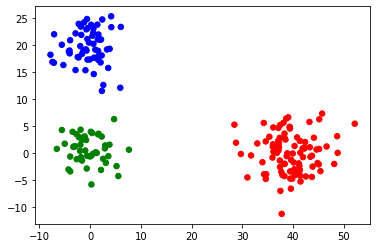

In [6]:
colors = ['red', 'green', 'blue']
assigned_colors = []
for i in range(n):
    assigned_colors.append(colors[clusters[i]])
plt.scatter(X[:, 0], X[:, 1], color=assigned_colors, s=30)
plt.plot()

### Plot log-likelihood vs step, and estimation error vs step

Text(0.5, 1.0, 'log likelihood')

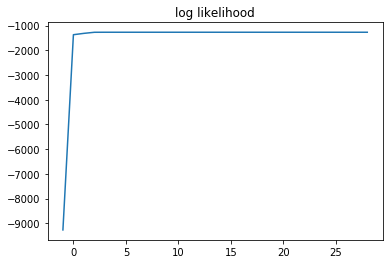

In [7]:
log_likelihoods = np.array(log_likelihoods)
est_errors = np.array(est_errors)

plt.plot(log_likelihoods[:, 0], log_likelihoods[:, 1])
plt.title("log likelihood")

Text(0.5, 1.0, 'estimation error')

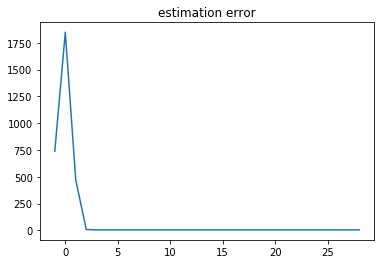

In [8]:
plt.plot(est_errors[:, 0], est_errors[:, 1])
plt.title("estimation error")